In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import regex as re
from pathlib import Path
from importlib import reload
from pprint import pp
from collections import Counter

In [186]:
import utils as u
import analysis as a

In [187]:
# Call to reload an imported module if it has been updated
reload(a)

<module 'analysis' from '/home/ruskirin/Documents/Course Material/Assignments/m450/reddit-assortativity-analysis/analysis.py'>

In [5]:
%matplotlib notebook
plt.rcParams.update({'axes.titlesize': 'large'})

In [6]:
data_path = Path('data/chain_networks')
data_path.exists()

True

In [7]:
subreds_raw = dict()

In [8]:
# All the subreddits and their paths
subreddits_paths = [sr for sr in data_path.iterdir()]
subreddits = [sr.stem for sr in data_path.iterdir()]
sorted(subreddits)

['2007scape',
 '240sx',
 '24hoursupport',
 '3DS',
 '3Dprinting',
 '3amjokes',
 '3dsFCswap',
 '49ers',
 '4chan',
 '4x4',
 '90daysgoal',
 '911truth',
 'ABDL',
 'ABraThatFits',
 'ACMilan',
 'ACTrade',
 'ADHD',
 'AFL',
 'AMA',
 'ANormalDayInRussia',
 'AbandonedPorn',
 'Accounting',
 'ActionFigures',
 'Adelaide',
 'AdoptMyVillager',
 'Advice',
 'AdviceAnimals',
 'AfterEffects',
 'AirForce',
 'Albany',
 'Albuquerque',
 'Aleague',
 'AlienBlue',
 'AllThingsTerran',
 'AmIFreeToGo',
 'AmISexy',
 'Amateur',
 'AmateurArchives',
 'AmericanHorrorStory',
 'Amsterdam',
 'Anarchism',
 'Anarcho_Capitalism',
 'Anarchy101',
 'Android',
 'AndroidGaming',
 'AndroidQuestions',
 'AnimalCrossing',
 'AnimalsBeingBros',
 'AnimalsBeingJerks',
 'AnimeFigures',
 'AnimeSketch',
 'Animesuggest',
 'AnnArbor',
 'AntiJokes',
 'Anticonsumption',
 'Anxiety',
 'AnythingGoesNews',
 'AppHookup',
 'AppalachianTrail',
 'Aquariums',
 'ArcherFX',
 'Archery',
 'Argentinacirclejerk',
 'Art',
 'ArtisanVideos',
 'ArtistLounge',
 'As

#### Non-political Subreddits by Group:
Analysis of political subreddits must be compared to other groups in order to observe any trends. Ideally I would find a group of subreddits that are as closely resembling of natural social groups as possible, so as to perhaps show that advice-giving subreddits or those dealing with sensitive topics (eg. politics, sports) show great homophilic tendincies or high betweenness. This would support the hypothesis that reddit is not a great place to turn to for advice or gaining perspective, as the communities that purport to do that are biased.

The groups chosen to be sampled are those related to: 
<ul>
    <li>gaming: 
        <ul>
            <li>CrusaderKings</li>
            <li>Diablo</li>
            <li>GTAV</li>
            <li>2007scape</li>
            <li>HalfLife</li>
        </ul>
    </li>
    <li>geographical(dedicated to specific cities/countries): 
        <ul>
            <li>Amsterdam</li>
            <li>Brooklyn</li>
            <li>Hawaii</li>
            <li>Israel</li>
            <li>LosAngeles</li>
        </ul>
    </li>
    <li>medicine(dedicated to certain mental or physical conditions): 
        <ul>
            <li>ChronicPain</li>
            <li>Fibromyalgia</li>
            <li>alcoholism</li>
            <li>bipolar</li>
            <li>socialanxiety</li>
        </ul>
    </li>
    <li>sports: 
        <ul>
            <li>Bowling</li>
            <li>Kayaking</li>
            <li>nyjets</li>
            <li>powerlifting</li>
            <li>lacrosse</li>
        </ul>
    </li>
    <li>religion: 
        <ul>
            <li>Catholicism</li>
            <li>Christianity</li>
            <li>Buddhism</li>
            <li>Judaism</li>
            <li>islam</li>
        </ul>
    </li>
    <li>QA/advice: 
        <ul>
            <li>AskEngineers</li>
            <li>askphilosophy</li>
            <li>AskFeminists</li>
            <li>AskNYC</li>
            <li>AskPhotography</li>
        </ul>
    </li>
</ul>

Each group will have at most 5 subreddits, as combing through ~2000 subreddits and partitioning each is very time-consuming. Choosing of the subreddits was done by simply scrolling through an alphabetically-ordered list and choosing based on recognition or personal preference (thought subreddit X was more representative of the selected group than subreddit Y) -- therefore the choice was not random and **is biased**. Analyzing subreddits with >1 million members would be too computationally-demanding to perform calculations on, so I restricted focus to the smaller ones, which could be a bit more niche and perhaps in some way bias the results.

In [9]:
topics_game = ['CrusaderKings', 'Diablo', 'GTAV', '2007scape', 'HalfLife']
topics_geo = ['Amsterdam', 'Brooklyn', 'Hawaii', 'Israel', 'LosAngeles']
topics_med = ['ChronicPain', 'Fibromyalgia', 'alcoholism', 'bipolar', 'socialanxiety']
topics_sport = ['Bowling', 'Kayaking', 'nyjets', 'powerlifting', 'lacrosse']
topics_religion = ['Catholicism', 'Christianity', 'Buddhism', 'Judaism', 'islam']
topics_ask = ['AskEngineers', 'askphilosophy', 'AskFeminists', 'AskNYC', 'AskPhotography']

In [10]:
paths_game = [data_path/f'{topic}.json' for topic in topics_game]
paths_geo = [data_path/f'{topic}.json' for topic in topics_geo]
paths_med = [data_path/f'{topic}.json' for topic in topics_med]
paths_sport = [data_path/f'{topic}.json' for topic in topics_sport]
paths_religion = [data_path/f'{topic}.json' for topic in topics_religion]
paths_ask = [data_path/f'{topic}.json' for topic in topics_ask]

In [11]:
paths = {'game': paths_game, 'geo': paths_geo, 'med': paths_med, 'sport': paths_sport, 'religion': paths_religion, 'ask': paths_ask}

In [12]:
paths_valid = []

for ps in paths.values():
    paths_valid.append([(sr.stem, sr in subreddits_paths) for sr in ps])
    
paths_valid

[[('CrusaderKings', True),
  ('Diablo', True),
  ('GTAV', True),
  ('2007scape', True),
  ('HalfLife', True)],
 [('Amsterdam', True),
  ('Brooklyn', True),
  ('Hawaii', True),
  ('Israel', True),
  ('LosAngeles', True)],
 [('ChronicPain', True),
  ('Fibromyalgia', True),
  ('alcoholism', True),
  ('bipolar', True),
  ('socialanxiety', True)],
 [('Bowling', True),
  ('Kayaking', True),
  ('nyjets', True),
  ('powerlifting', True),
  ('lacrosse', True)],
 [('Catholicism', True),
  ('Christianity', True),
  ('Buddhism', True),
  ('Judaism', True),
  ('islam', True)],
 [('AskEngineers', True),
  ('askphilosophy', True),
  ('AskFeminists', True),
  ('AskNYC', True),
  ('AskPhotography', True)]]

In [13]:
all([p[1] for p in paths])

True

## Surface Analysis:
Will do this a group at a time to not overload the RAM.

In [14]:
subreddit_params = pd.DataFrame()

In [15]:
for name, path in paths.items():
    nets = dict([u.digraph_from_path(p.stem, p) for p in path])
    sr_group = [name]*len(nets)
    params = a.get_graph_base_stats(nets)
    params.insert(0, 'group', sr_group)
    
    subreddit_params = pd.concat([subreddit_params, params], axis=0)

In [16]:
subreddit_params

,group,nodes,edges,density,nodes_largest_strong_comp,pct_nodes_largest_strong_comp,nodes_deg_one,pct_nodes_deg_one,pagerank_max,pagerank_avg,reciprocity
CrusaderKings,game,7738,26367,0.000440,2394,0.309382,1612,0.208323,0.008198,0.000129,0.151553
Diablo,game,32420,107055,0.000102,10522,0.324553,6843,0.211073,0.008867,0.000031,0.098024
GTAV,game,8470,19440,0.000271,1902,0.224557,2334,0.275561,0.006093,0.000118,0.203909
2007scape,game,13285,58847,0.000333,4316,0.324878,3025,0.227700,0.007487,0.000075,0.177375
HalfLife,game,2844,6115,0.000756,463,0.162799,803,0.282349,0.023426,0.000352,0.156664
Amsterdam,geo,1820,3987,0.001204,225,0.123626,498,0.273626,0.046887,0.000549,0.183095
Brooklyn,geo,2174,4424,0.000936,406,0.186753,613,0.281969,0.010847,0.000460,0.173146
Hawaii,geo,2103,5401,0.001222,435,0.206847,575,0.273419,0.022744,0.000476,0.163673
Israel,geo,4222,15575,0.000874,1200,0.284225,933,0.220985,0.014523,0.000237,0.191332
LosAngeles,geo,11891,30566,0.000216,2241,0.188462,3075,0.258599,0.008429,0.000084,0.144016


In [190]:
n = dict([u.digraph_from_path(p.stem, p) for p in paths_game])
n

{'CrusaderKings': <networkx.classes.digraph.DiGraph at 0x7ff665910790>,
 'Diablo': <networkx.classes.digraph.DiGraph at 0x7ff6656fd690>,
 'GTAV': <networkx.classes.digraph.DiGraph at 0x7ff663782b30>,
 '2007scape': <networkx.classes.digraph.DiGraph at 0x7ff665763a30>,
 'HalfLife': <networkx.classes.digraph.DiGraph at 0x7ff6657620b0>}

In [ ]:
a.cosine_similarity(n['Diablo'])

### Visualizing Differences

In [16]:
# Normalize the base stats for each subreddit relative to total sum 
#   across all the subreddits in the group
normalized_params = a.z_normalize(subreddit_params, sort_by=['density'])
normalized_params = normalized_params.sort_values(by=['group', 'pagerank_max'], ascending=False)
normalized_params

,group,nodes,edges,density,nodes_largest_strong_comp,pct_nodes_largest_strong_comp,nodes_deg_one,pct_nodes_deg_one,pagerank_max,pagerank_avg,reciprocity
Bowling,sport,-0.643696,-0.585065,1.613901,-0.504361,0.463136,-0.732727,-0.816751,-0.023240,1.494318,-0.181482
Kayaking,sport,-0.555942,-0.576087,0.046838,-0.597283,-2.051464,-0.516059,1.736002,-0.054857,0.566500,0.469485
lacrosse,sport,-0.518851,-0.537852,0.041485,-0.469999,-0.390963,-0.527538,0.534101,-0.114606,0.339160,-1.103051
powerlifting,sport,-0.402902,-0.409109,-0.069588,-0.355298,0.092186,-0.450771,-0.394123,-0.347912,-0.108152,0.828843
nyjets,sport,-0.395815,-0.318927,0.268983,-0.273023,0.840509,-0.383331,0.352488,-0.371652,-0.127484,-0.271549
Judaism,religion,-0.460047,-0.352307,0.711936,-0.401275,0.013824,-0.535430,-0.705299,0.702125,0.075873,0.931392
Buddhism,religion,-0.013741,-0.104001,-0.659745,-0.188329,-0.410746,0.093770,0.335918,-0.290421,-0.664092,0.413279
Catholicism,religion,-0.207190,-0.068949,-0.077617,-0.162194,0.486807,-0.286476,-0.858260,-0.414263,-0.476593,1.217279
islam,religion,0.081551,0.212940,-0.505849,0.112216,0.707294,0.001220,-0.907501,-0.576859,-0.726737,1.077050
Christianity,religion,2.193965,2.757652,-1.069243,1.580096,0.305515,1.903168,-1.335247,-1.081817,-1.096833,0.632198


In [17]:
exclude_cols = ['nodes_largest_strong_comp', 'nodes_deg_one', 'group']
include = [c not in exclude_cols for c in subreddit_params.columns]

In [ ]:
plt.clf()

<IPython.core.display.Javascript object>


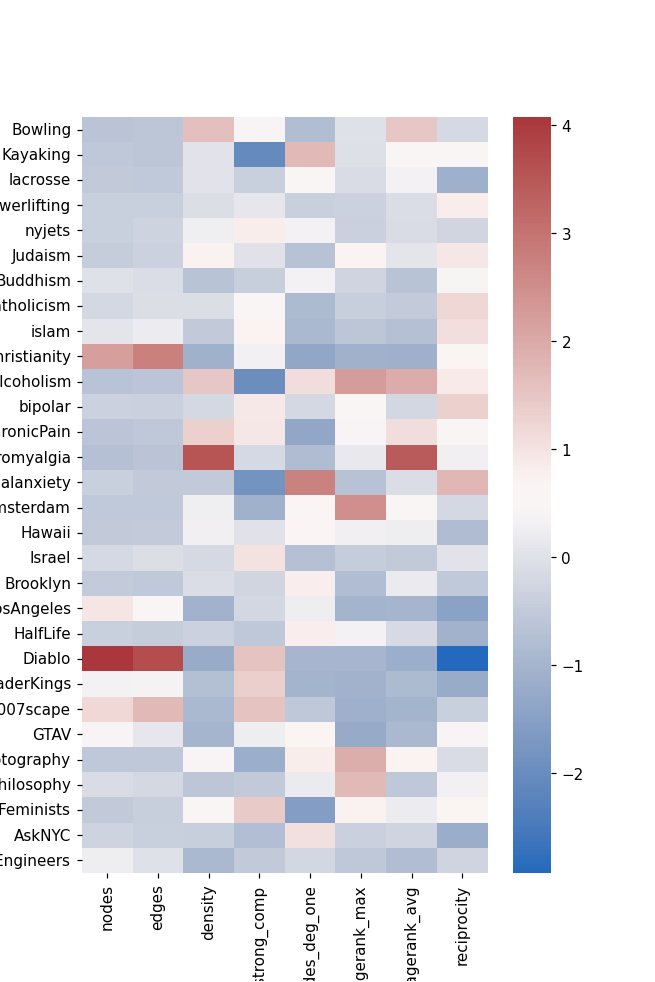

In [19]:
fig, ax = plt.subplots(figsize=(6,9))

In [20]:
plt.cla()
sns.heatmap(normalized_params.loc[:, include], cmap=sns.color_palette("vlag", as_cmap=True))

<AxesSubplot: >

plt.savefig('images/base-stats-znormalized.png', bbox_inches='tight')

In [41]:
group_params = normalized_params.groupby(['group']).median().drop(['nodes_largest_strong_comp', 'nodes_deg_one'], axis=1)
group_params

,nodes,edges,density,pct_nodes_largest_strong_comp,pct_nodes_deg_one,pagerank_max,pagerank_avg,reciprocity
group,,,,,,,,
ask,-0.319370,-0.394133,-0.420203,-0.512258,0.178508,0.716424,-0.300936,-0.115086
game,0.461213,0.372941,-0.908656,1.345408,-0.552673,-1.039539,-0.883503,-1.055635
geo,-0.488092,-0.482601,-0.101705,-0.230414,0.593067,-0.463314,0.189658,-0.530153
med,-0.615651,-0.558541,1.334211,-0.177303,-0.205380,0.451365,1.109379,0.891349
religion,-0.013741,-0.068949,-0.505849,0.305515,-0.858260,-0.414263,-0.664092,0.931392
sport,-0.518851,-0.537852,0.046838,0.092186,0.352488,-0.114606,0.339160,-0.181482


<IPython.core.display.Javascript object>


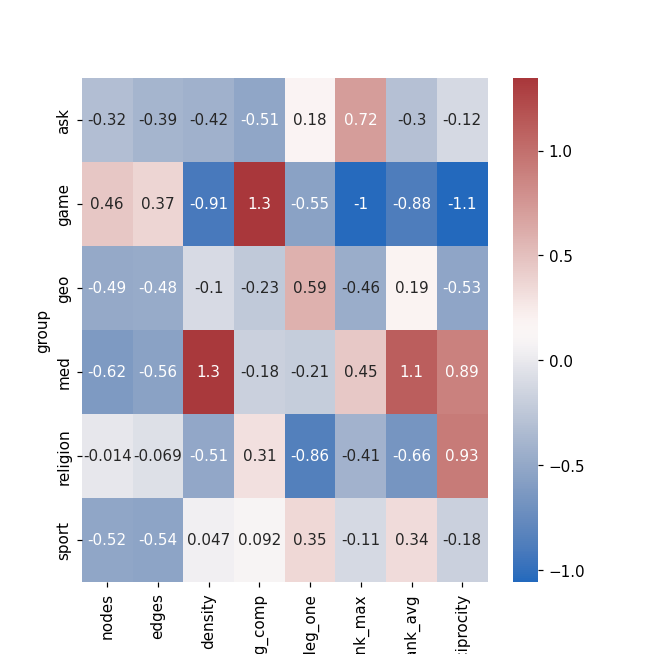

In [42]:
fig,ax = plt.subplots(figsize=(6,6))

In [43]:
# fig.delaxes(fig.axes[1])
plt.cla()
sns.heatmap(group_params, cmap=sns.color_palette("vlag", as_cmap=True), annot=True)

<AxesSubplot: ylabel='group'>

### NOTE:
A pattern of group behavior seems to be emerging:
<ul>
    <li>
        sports:
        <ul>
            <li>seems most average of the groups</li>
        </ul>
    </li>
    <li>
        religion:
        <ul>
            <li>higher reciprocity</li>
            <li>normally distrib pagerank</li>
            <li>lower pagerank</li>
            <li></li>
        </ul>
    </li>
    <li>
        med:
        <ul>
            <li>high density</li>
            <li>strongest comp high variance?</li>
            <li>higher pagerank max, high pagerank average</li>
            <li>higher reciprocity</li>
        </ul>
    </li>
    <li>
        geo:
        <ul>
            <li></li>
            <li></li>
            <li></li>
            <li></li>
        </ul>
    </li>
    <li>
        games:
        <ul>
            <li></li>
            <li></li>
            <li></li>
            <li></li>
        </ul>
    </li>
    <li>
        ask:
        <ul>
            <li></li>
            <li></li>
            <li></li>
            <li></li>
        </ul>
    </li>
    <li>NOTE: some stats could be influenced by size of communities (alcoholism), check for that</li>
    <li>NOTE: percent largest strongly-connected component and degree one nodes are basically inverse values</li>
</ul>

### IDEAS:
<ul>
    <li></li>
</ul>

### Game

## Strong Component Analysis

In [20]:
# For later analyses
strongest_comps = a.get_subset_strongly_conn_components(nets, True)
strongest_game = [nets[n].subgraph(strongest_comps[n]) for n in nets.keys()]

## Random Graphs: